# Experimenting with BERT Features Notebook

In [ ]:
# Add imports
# Load the ushahidi dataset and print out first rows
# Perform text preprocessing - similar to what i did for the baseline classifiers - create clean text
# Train first XLM Roberta model and see how it perfroms
# Might try training all models this weekend, and then the next goal could be to see how to use the
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import json
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import TweetTokenizer
import textwrap
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth',1000)
from itertools import cycle
import random
import torch

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80, initial_indent='    ',
                               subsequent_indent='    ')
nltk.download('stopwords')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# # Set the seed to make the results reproducible :)
# # Set the seed value all over the place to make this reproducible.
# seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data from drive

In [ ]:
# Load data
model_data = pd.read_csv('/content/drive/My Drive/thesis/labelled_election_reports.csv', encoding='utf-8')
train_data = pd.read_csv('/content/drive/My Drive/thesis/train_election_reports.csv', encoding='utf-8')
val_data = pd.read_csv('/content/drive/My Drive/thesis/val_election_reports.csv', encoding='utf-8')
test_data = pd.read_csv('/content/drive/My Drive/thesis/test_election_reports.csv', encoding='utf-8')

In [ ]:
# Rewrite code to splir

In [ ]:
print(f'Full Labled Data: {model_data.shape}')
print(f'   Training size: {train_data.shape}')
print(f' Validation size: {val_data.shape}')
print(f'       Test size: {test_data.shape}')

Full Labled Data: (14181, 14)
   Training size: (9926, 14)
 Validation size: (1405, 14)
       Test size: (2850, 14)


In [ ]:
assert((len(train_data) + len(val_data) + len(test_data)) == len(model_data))

In [ ]:
labeller = LabelEncoder()
labeller.fit(train_data["informative_label"])
train_data["informative_target"] = labeller.transform(train_data["informative_label"])
val_data["informative_target"] = labeller.transform(val_data["informative_label"])
test_data["informative_target"] = labeller.transform(test_data["informative_label"])

In [ ]:
mapping = dict(zip(labeller.classes_, range(len(labeller.classes_))))
print(mapping)

{'Informative': 0, 'Non-Informative': 1}


## Create the context for each election report

In [ ]:
sep = ' [SEP] '
def get_context(df, support_df, context_size=3):
  '''
  This function takes two dataframes, the first, df - is the dataframe to calculate
  context embeddings for while the support df is the reference to use to check the
  context, in the case of train data, both the df and support df will be the same,
  this is to ensure that no test data leaks into the training context embeddings. For
  test embeddings, the support df will be the whole dataset
  '''
  contexts = []
  sorted_dates = df.sort_values('date')['date']
  dates_list = sorted_dates.to_list()
  # Iterate over rows using iterrows()
  for index, row in df.iterrows():
    current_date = row['date']
    current_date_index = dates_list.index(current_date)
    previous_posts = dates_list[max(0, current_date_index - context_size) : current_date_index]
    context = ""
    for idx, dt in enumerate(previous_posts):
      record = support_df[support_df['date'] == dt].iloc[0]
      # Only consider context fromt the same election
      if record['Election Date'] == row['Election Date']:
        context += (record.normalized_text + sep)
    contexts.append(context)
  return contexts

In [ ]:
train_contexts = get_context(train_data, train_data)

In [ ]:
train_contexts[:1]

['Here at Oljoroorok we are still queuing to vote . So cold , raining and the queing officers are not doing their work .. [SEP] During the day , August 8 , 2017 , there were reported incidences of voter misinformation - that registered voters NOT in the area they were registered in would be allowed to vote in the presidential race at any polling station in the country . [SEP] 6 gas lamps are available #Awendo [SEP] ']

In [ ]:
test_contexts = get_context(test_data, model_data)

In [ ]:
train_val_combined = pd.concat([train_data, val_data])

In [ ]:
val_contexts = get_context(val_data, train_val_combined)

In [ ]:
train_data["context"] = train_contexts
val_data["context"] = val_contexts
test_data["context"] = test_contexts

In [ ]:
train_data['date'] = pd.to_datetime(train_data['date'])
val_data['date'] = pd.to_datetime(val_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [ ]:
# Possibly save train, test and val embeddings to save on time, preprocessing time

In [ ]:
sep = ' [SEP] '
def combine_features(df):
  sentences = []
  labels = []
  print('Combining features into strings...')
  # For each of the samples...
  for index, row in df.iterrows():
      # Piece it together...
      context = row["context"]
      text = row["normalized_text"]
      combined_text = context + text

      sentences.append(text)
      labels.append(row["informative_target"])
  print('  DONE.')
  print('Dataset contains {:,} samples.'.format(len(sentences)))
  return sentences, labels

In [ ]:
from sklearn.preprocessing import QuantileTransformer

# Create an instance of QuantileTransformer
transformer = QuantileTransformer(random_state=0)
# Reshape the input data to have the appropriate dimensions
train_election_distance_reshaped = train_data['election_distance'].values.reshape(-1, 1)
transformer.fit(train_election_distance_reshaped)

QuantileTransformer(random_state=0)

In [ ]:
train_data['election_distance_transformed'] = transformer.transform(train_election_distance_reshaped)

In [ ]:
val_election_distance_reshaped = val_data['election_distance_abs'].values.reshape(-1, 1)
val_data['election_distance_transformed'] = transformer.transform(val_election_distance_reshaped)

In [ ]:
test_election_distance_reshaped = test_data['election_distance_abs'].values.reshape(-1, 1)
test_data['election_distance_transformed'] = transformer.transform(test_election_distance_reshaped)

In [ ]:
informative_train_data = train_data[train_data['informative_label'] == 'Informative']
informative_val_data = val_data[val_data['informative_label'] == 'Informative']
informative_test_data = test_data[test_data['informative_label'] == 'Informative']

print(f'  Training size: {informative_train_data.shape}')
print(f'Validation size: {informative_val_data.shape}')
print(f'      Test size: {informative_test_data.shape}')

inf_labeller = LabelEncoder()
inf_labeller.fit(informative_train_data["merged_label"])
informative_train_data["target"] = inf_labeller.transform(informative_train_data["merged_label"])
informative_val_data["target"] = inf_labeller.transform(informative_val_data["merged_label"])
informative_test_data["target"] = inf_labeller.transform(informative_test_data["merged_label"])

inf_mapping = dict(zip(inf_labeller.classes_, range(len(inf_labeller.classes_))))
print(inf_mapping)

  Training size: (3414, 17)
Validation size: (483, 17)
      Test size: (980, 17)
{'Counting and Results': 0, 'Political Rallies': 1, 'Positive Events': 2, 'Security Issues': 3, 'Voting Issues': 4}


<ipython-input-23-ed327d469efc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_train_data["target"] = inf_labeller.transform(informative_train_data["merged_label"])
<ipython-input-23-ed327d469efc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_val_data["target"] = inf_labeller.transform(informative_val_data["merged_label"])
<ipython-input-23-ed327d469efc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [ ]:
informative_train_data['context'].head(3)

0                                                                                                                                                                                               Here at Oljoroorok we are still queuing to vote . So cold , raining and the queing officers are not doing their work .. [SEP] During the day , August 8 , 2017 , there were reported incidences of voter misinformation - that registered voters NOT in the area they were registered in would be allowed to vote in the presidential race at any polling station in the country . [SEP] 6 gas lamps are available #Awendo [SEP] 
2                                                                                                                                                                                                                                                                                                                                                                 Excellent job by IEBC [SEP] The Dist

## Split data for informative binary classifcation task or informative types multiclassification task

In [ ]:
# # Uncomment this section of code to train the information types classificationt task
# train_sentences, train_targets = combine_features(informative_train_data)
# val_sentences, val_targets = combine_features(informative_val_data)
# test_sentences, test_targets = combine_features(informative_test_data)

In [ ]:
train_contexts = train_data.context.values
test_contexts = test_data.context.values
val_contexts = val_data.context.values

In [ ]:
np.unique(train_targets)

array([0, 1])

In [ ]:
train_sentences, train_targets = combine_features(train_data)
val_sentences, val_targets = combine_features(val_data)
test_sentences, test_targets = combine_features(test_data)

Combining features into strings...
  DONE.
Dataset contains 9,926 samples.
Combining features into strings...
  DONE.
Dataset contains 1,405 samples.
Combining features into strings...
  DONE.
Dataset contains 2,850 samples.


In [ ]:
train_sentences[:2]

["Here at Oljoroorok we are still queuing to vote . So cold , raining and the queing officers are not doing their work .. [SEP] During the day , August 8 , 2017 , there were reported incidences of voter misinformation - that registered voters NOT in the area they were registered in would be allowed to vote in the presidential race at any polling station in the country . [SEP] 6 gas lamps are available #Awendo [SEP] Presiding officer captured all rejected ballot papers on form marked ‘ Rejected ' #KURIA EAST #MUTINITI",
 "Happy Elections Day to all Kenyans . Spreading peace and unity this election season . [SEP] election : Rahema Marjani is frustrated . “ I 've been here since 6 and I did n't find my name on the list . I 'm in line hoping to vote . The time I spent here I could have made ugali for my children and washed some clothes to make money . ” #kenyadecides [SEP] Democracy ensures Societal equality . It is your right to vote Practice it . Wishing Us a peaceful election ahead . #K

## Tokenize sentences using bert specific tokenizer

In [ ]:
# Check whether GPU is detected
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

In [ ]:
print('Loading model to GPU...')

# Connect to the GPU.
device = torch.device('cuda')

Loading model to GPU...


In [ ]:
# This section of code creates the sentiment scores for each election report
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

cardiff_tokenizer = AutoTokenizer.from_pretrained(MODEL)
cardiff_config = AutoConfig.from_pretrained(MODEL)

# PT
cardiff_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Add the model to the gpu device
cardiff_model.to(device)

# Fn to get the sentiment scores - returns an array of shape n*3, where n is the number of
# sentences passed as an argument and 3 represents the float values for negative, neutral and positive
def get_sentiment_scores(sentences):
  sentiment_scores = []
  for sent in sentences:
    text = preprocess(sent)
    encoded_input = cardiff_tokenizer(text, return_tensors='pt').to(device)
    output = cardiff_model(**encoded_input)
    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    sentiment_scores.append(scores)
  return sentiment_scores


In [ ]:
model_sentiments = get_sentiment_scores(model_data.text.values)

In [ ]:
sentiment = ['negative', 'neutral', 'positive']
train_sentiments = get_sentiment_scores(train_data.text.values)
val_sentiments = get_sentiment_scores(val_data.text.values)
test_sentiments = get_sentiment_scores(test_data.text.values)
train_data[sentiment] = pd.DataFrame(train_sentiments)
val_data[sentiment] = pd.DataFrame(val_sentiments)
test_data[sentiment] = pd.DataFrame(test_sentiments)

In [ ]:
labelled_data_sentiments = get_sentiment_scores(train_data.text.values)

In [ ]:
informative_train_contexts = informative_train_data.context
informative_val_contexts = informative_val_data.context
informative_test_contexts = informative_test_data.context

In [ ]:
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [ ]:
# Print the original sentence.
print(' Original: ', train_sentences[10])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_sentences[10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[10])))

 Original:  Why is @USER prone to negative news & administrative misconduct alwys & they can't learn from it knowing quit well its entrusted wth very sensitive & delicate mandate . Now A foreigner pops in JKIA wth sensitive material in his luggage & IEBC defends it like its normal [SEP] hakuna kitu ka io ... chebukati ni Ruto na ruto ni chebukati [SEP] Ehehehhehehe . He is a joke . Chebukati . So Materials for IEBC are carried in private bags ? [SEP] It does n't have to be stated literally . The letter says it all . I am not defending State Mischief in the matter as I am lamenting IEBC carelessness and ineptitude
Tokenized:  ['▁Why', '▁is', '▁@', 'U', 'SER', '▁pro', 'ne', '▁to', '▁negative', '▁news', '▁&', '▁administrative', '▁mis', 'con', 'duct', '▁al', 'wys', '▁&', '▁they', '▁can', "'", 't', '▁learn', '▁from', '▁it', '▁knowing', '▁qui', 't', '▁well', '▁its', '▁en', 'trust', 'ed', '▁w', 'th', '▁very', '▁sensitive', '▁&', '▁delicat', 'e', '▁mandat', 'e', '▁', '.', '▁Now', '▁A', '▁forei

In [ ]:
# Measure the maximum length of the sentences
max_len = 0
lengths_en = []
# For every sentence...
for sent in train_sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Record the length.
    lengths_en.append(len(input_ids))
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  306


In [ ]:
print('Min length: {:,} tokens'.format(min(lengths_en)))
print('Max length: {:,} tokens'.format(max(lengths_en)))
print('Median length: {:,} tokens'.format(int(np.median(lengths_en))))

Min length: 5 tokens
Max length: 306 tokens
Median length: 40 tokens


<ipython-input-152-276b95ef4bff>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lengths_en, kde=False, rug=False)


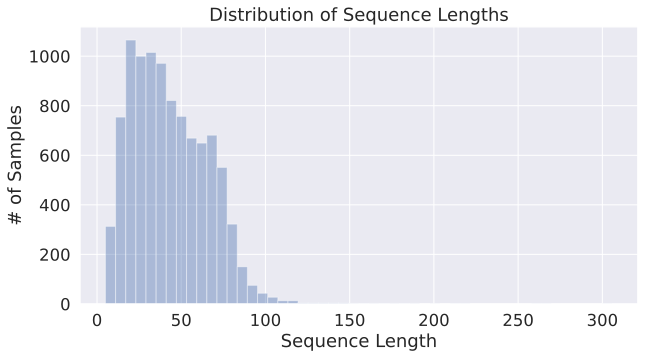

In [ ]:
# Look at the token distribution

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(lengths_en, kde=False, rug=False)

plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('# of Samples')

plt.show()

In [ ]:
max_len = 128

# Count the number of sequences that are longer than `max_len` tokens.
num_truncated = np.sum(np.greater(lengths_en, max_len))

# Compare this to the total number of training sentences.
num_sentences = len(lengths_en)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than {:} tokens.'.format(num_truncated, num_sentences, prcnt, max_len))

30 of 9,926 sentences (0.3%) in the training set are longer than 128 tokens.


In [ ]:
def tokenize(sentences, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_len,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          truncation_strategy='only_first',
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])

  return input_ids, attention_masks, labels

In [ ]:
train_input_ids, train_attention_masks, train_labels = tokenize(train_sentences, train_targets)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Presiding officer captured all rejected ballot papers on form marked ‘ Rejected ' #KURIA EAST #MUTINITI
Token IDs: tensor([     0,  20703,  86675,  93324, 141621,     71,    756,      6,  34590,
         89829,  16446,    818,  15122,      7,     98,   3173,  94419,    204,
           853,    236,  89829,    242,    468,  23458,  32410,    241,  48963,
           468,  23330,  54390,  35522,      2,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,   

In [ ]:
val_input_ids, val_attention_masks, val_labels = tokenize(val_sentences, val_targets)

Original:  Is comprehension a struggle for you ? What were those gadgets containing sensitive election information going to do at someone 's apartment instead of going straight to IEBC office . The problem with some of you is you 're not engaging your brains on this subject
Token IDs: tensor([     0,   2071,  46683,   3220,   6889,     10, 151994,    100,    398,
           705,   4865,   3542,   8382,  88100,      7,  70541,    214, 191125,
         81843,   4677,   7730,     47,     54,     99,  22008,    242,      7,
        127451,  64457,    111,   7730,  80560,     47,     87, 171408,  23179,
             6,      5,    581,   2967,    678,   3060,    111,    398,     83,
           398,    242,    107,    959,  44173,   9966,    935,  78574,      7,
            98,    903,  28368,      2,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,   

In [ ]:
test_input_ids, test_attention_masks, test_labels = tokenize(test_sentences, test_targets)

Original:  IEBC is already divided just like in 2017 . Marjan the CEO is saying things that are totally different from chebukati . When interviewed by journalists a lot of things came to light on how they are divided . We can't trace who stands to benefit from this division
Token IDs: tensor([     0,     87, 171408,     83,  21771, 101637,     71,   1660,   1884,
            23,    505,      6,      5,   1784,   2864,     70,  45733,     83,
         54433,   8966,    450,    621, 112668,  12921,   1295,    290,  33426,
           118,      6,      5,  14847,  33683,    297,    390,  32485,      7,
            10,   5915,    111,   8966,  21449,     47,  22729,     98,   3642,
          1836,    621, 101637,     71,      6,      5,   1401,    831,     25,
            18, 144851,   2750,   9157,      7,     47,  68073,   1295,    903,
         91853,      2,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,   

## Create datasets and dataloaders

In [ ]:
from torch.utils.data.dataset import TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
val_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# # For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
labels = train_dataset[:][2].numpy()

In [ ]:
# Estimate the class weights to be used in the model training
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights,dtype=torch.float)

In [ ]:
weights={}
for index, weight in enumerate(class_weights) :
  weights[index]=weight

print(weights)

{0: tensor(1.4537), 1: tensor(0.7621)}


## Initialise XLMRoberta models

In [ ]:
from transformers import XLMRobertaForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoModel
import torch

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

for param in xlmr_model.parameters():
    param.requires_grad = True

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.den

In [ ]:
# Confirm whether all layers are trainable
all(p.requires_grad for p in xlmr_model.parameters())

True

In [ ]:
print('Loading model to GPU...')

# Connect to the GPU.
device = torch.device('cuda')

# Report what GPU we were granted.
print('  GPU:', torch.cuda.get_device_name(0))

# Copy the initial model weights to the GPU.
desc = xlmr_model.to(device)

print('DONE.')

Loading model to GPU...
  GPU: NVIDIA A100-SXM4-40GB
DONE.


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [ ]:
# sentiment = ['negative', 'neutral', 'positive']
# informative_train_data[sentiment] = train_data[sentiment].iloc[informative_train_data.index.values]
# informative_test_data[sentiment] = test_data[sentiment].iloc[informative_test_data.index.values]
# informative_val_data[sentiment] = val_data[sentiment].iloc[informative_val_data.index.values]

In [ ]:
from transformers import AdamW

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = torch.optim.AdamW(xlmr_model.parameters(),
                  lr = 1e-5, # args.learning_rate
                )


from transformers import get_linear_schedule_with_warmup

# Number of training epochs.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    xlmr_model.train()

    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader),
                num_desired_updates = 10
            )

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update.
        if (step % update_interval) == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        xlmr_model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = xlmr_model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       return_dict=True)

        logits = result.logits
        # loss = result.loss

        criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
        loss = criterion(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(xlmr_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    xlmr_model.eval()

    # Tracking variables
    total_eval_loss = 0


    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in val_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = xlmr_model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        logits = result.logits

        # Calculate the loss without applying class weights
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(logits, b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Measure validation accuracy...

    # Combine the results across all batches.
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # For each sample, pick the label (0, 1, or 2) with the highest score.
    predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

    # Calculate the validation accuracy.
    val_accuracy = (predicted_labels == flat_true_labels).mean()

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    30  of    311.    Elapsed: 0:00:05.
  Batch    60  of    311.    Elapsed: 0:00:11.
  Batch    90  of    311.    Elapsed: 0:00:16.
  Batch   120  of    311.    Elapsed: 0:00:21.
  Batch   150  of    311.    Elapsed: 0:00:27.
  Batch   180  of    311.    Elapsed: 0:00:32.
  Batch   210  of    311.    Elapsed: 0:00:37.
  Batch   240  of    311.    Elapsed: 0:00:42.
  Batch   270  of    311.    Elapsed: 0:00:48.
  Batch   300  of    311.    Elapsed: 0:00:53.

  Average training loss: 0.58
  Training epoch took: 0:00:55

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.53
  Validation took: 0:00:02

======== Epoch 2 / 2 ========
Training...
  Batch    30  of    311.    Elapsed: 0:00:05.
  Batch    60  of    311.    Elapsed: 0:00:11.
  Batch    90  of    311.    Elapsed: 0:00:16.
  Batch   120  of    311.    Elapsed: 0:00:21.
  Batch   150  of    311.    Elapsed: 0:00:26.
  Batch   180  of    311.    Elapsed: 0:00:32.
  Batch  

In [ ]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.576151,0.526151,0.762989,0:00:55,0:00:02
2,0.496034,0.511523,0.767972,0:00:55,0:00:02


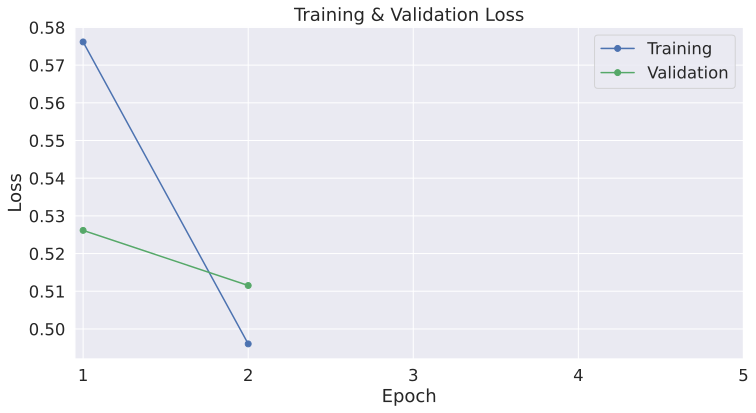

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4,5])

plt.show()

In [ ]:
# Prediction on test set

# Put model in evaluation mode
xlmr_model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = xlmr_model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE.')

DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

In [ ]:
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


<ipython-input-212-a1af80ea924d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


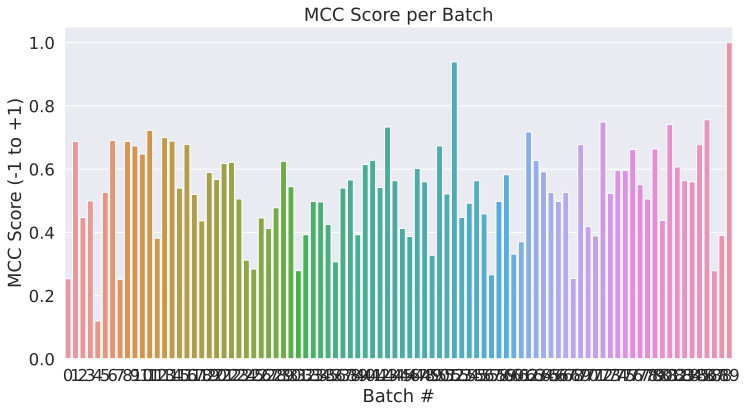

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

print(classification_report(flat_true_labels,
                                flat_predictions,
                                target_names=mapping.keys()))

Total MCC: 0.529
                 precision    recall  f1-score   support

    Informative       0.66      0.74      0.70       980
Non-Informative       0.86      0.80      0.83      1870

       accuracy                           0.78      2850
      macro avg       0.76      0.77      0.76      2850
   weighted avg       0.79      0.78      0.78      2850



In [ ]:
#Util function to plot confusion matrix with percentages
def plot_cm_with_percentages(labels, predictions, class_labels, name=""):
    # Compute confusion matrix
    cm = confusion_matrix(labels, predictions)

    # Calculate row-wise sums to get the total counts for each true label
    row_sums = cm.sum(axis=1, keepdims=True)

    # Calculate the percentages by dividing each element of the confusion matrix by its corresponding row sum
    cm_percentages = np.round((cm / row_sums) * 100, decimals=2)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8,6), dpi=100)

    # Scale up the size of all text
    sns.set(font_scale = 1.1)

    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format
    # annot = True: show the numbers in each heatmap cell
    # fmt = '.2f': show numbers as floats with 2 decimal places
    ax = sns.heatmap(cm_percentages, annot=True, fmt='.2f')

    # Format the annotations as percentages
    for _, value in enumerate(ax.collections[0].axes.texts):
        if value.get_text() != '0.00':
            value.set_text(f"{float(value.get_text()):.2f}%")

    # Set x-axis label and ticks
    ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
    ax.set_xticklabels(class_labels, rotation=45, ha='right')

    # Set y-axis label and ticks
    ax.set_ylabel("Gold Label", fontsize=14, labelpad=20)
    ax.set_yticklabels(class_labels, rotation=45, ha='right')

    # Set plot title
    ax.set_title("Confusion Matrix", fontsize=14, pad=20)

    from datetime import datetime

    # Generate a timestamp for the file name
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

    # Save the figure as an SVG file with timestamp in the file name
    file_name = f"/content/drive/My Drive/thesis/results/confusion_matrix_{name}_{timestamp}.svg"
    plt.savefig(file_name, format='svg')

    plt.show()


In [ ]:
 #Util function to plot confusion matrix
def plot_cm(labels, predictions, class_labels):
    # predictions has values in [0,1]
    cm = confusion_matrix(labels, predictions)
    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8,6), dpi=100)
    # Scale up the size of all text
    sns.set(font_scale = 1.1)
    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format
    # annot = True: show the numbers in each heatmap cell
    # fmt = 'd': show numbers as integers.
    ax = sns.heatmap(cm, annot=True, fmt='d', )
    # set x-axis label and ticks.

  # Set x-axis label and ticks
    ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
    ax.set_xticklabels(class_labels, rotation=45, ha='right')

    # Set y-axis label and ticks
    ax.set_ylabel("Gold Label", fontsize=14, labelpad=20)
    ax.set_yticklabels(class_labels, rotation=45, ha='right')

    # set plot title
    ax.set_title("Confusion Matrix", fontsize=14, pad=20)

    plt.show()

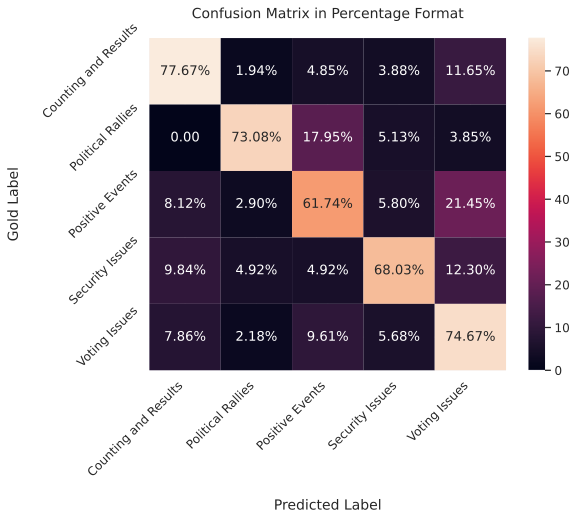

In [ ]:
plot_cm_with_percentages(flat_true_labels, flat_predictions, list(inf_mapping.keys()))

# Model Robustness: Init and run the models n times averaging to get the final results

In [ ]:
# Write code to initialize and run the models n number of times and average the results to improve results robustness

In [ ]:
def train_model(model, train_dataloader, epochs, class_weights, optimizer, scheduler):
  training_stats = []
  total_t0 = time.time()
  for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader),
                num_desired_updates = 10
            )
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update.
        # if (step % update_interval) == 0 and not step == 0:
        #     # Calculate elapsed time in minutes.
        #     elapsed = format_time(time.time() - t0)
        #     # Report progress.
        #     print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       return_dict=True)

        logits = result.logits
        # loss = result.loss

        criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
        loss = criterion(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

In [ ]:
def test_model(model,test_dataloader):
  # Put model in evaluation mode
  model.eval()
  # Tracking variables
  predictions , true_labels = [], []
  # Predict
  for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      return_dict=True)
    logits = result.logits
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  return predictions, true_labels

In [ ]:
def run_and_test_multiple_times(no_of_runs=1, num_labels=5, epochs=4, train_dataloader = train_dataloader, test_dataloader= test_dataloader, class_weights=class_weights):
  results = {}
  for i in range(0, no_of_runs):
    # Initialize model and load it to device every single time
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=num_labels)
    # Move model to device
    desc = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
                )

    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)
    # Measure the total training time for the whole run.
    total_t0 = time.time()
    print(f"Training Current run: {i+1}")
    train_model(model, train_dataloader, epochs, class_weights, optimizer, scheduler)
    print(f"Testing Current run: {i+1}")
    # Test model on test set
    predictions, true_labels = test_model(model, test_dataloader)
    results[f"Run {i+1}"] = (predictions, true_labels)
  return results

In [ ]:
results = run_and_test_multiple_times(no_of_runs=5, num_labels=2, epochs=2)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_pr

Training Current run: 1

======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.55
  Training epoch took: 0:00:55

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.47
  Training epoch took: 0:00:55
Testing Current run: 1


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_pr

Training Current run: 2

======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.57
  Training epoch took: 0:00:55

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.47
  Training epoch took: 0:00:55
Testing Current run: 2


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_pr

Training Current run: 3

======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.57
  Training epoch took: 0:00:55

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.47
  Training epoch took: 0:00:55
Testing Current run: 3


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_pr

Training Current run: 4

======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.57
  Training epoch took: 0:00:55

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.47
  Training epoch took: 0:00:55
Testing Current run: 4


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_pr

Training Current run: 5

======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.56
  Training epoch took: 0:00:55

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.48
  Training epoch took: 0:00:55
Testing Current run: 5


In [ ]:
def evaluate_model(predictions, true_labels, target_names=inf_mapping.keys()):
  # Combine the results across all batches.
  flat_predictions = np.concatenate(predictions, axis=0)

  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # Calculate the MCC
  mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

  print('Total MCC: %.3f' % mcc)

  print(classification_report(flat_true_labels,
                                  flat_predictions,
                                  target_names=target_names))

In [ ]:
predictions, true_labels = results['Run 5']

In [ ]:
evaluate_model(predictions, true_labels, mapping.keys())

Total MCC: 0.522
                 precision    recall  f1-score   support

    Informative       0.65      0.74      0.69       980
Non-Informative       0.85      0.79      0.82      1870

       accuracy                           0.78      2850
      macro avg       0.75      0.77      0.76      2850
   weighted avg       0.79      0.78      0.78      2850



In [ ]:
# Average all the runs in and save the results

In [ ]:
np.unique(train_targets)

array([0, 1])

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

def average_classification_report(predictions_dict, target_names=inf_mapping.keys()):
    num_runs = len(predictions_dict)
    labels = list(target_names)  # Get unique labels

    # Initialize variables to accumulate metrics
    avg_precision = {label: 0.0 for label in labels}
    avg_recall = {label: 0.0 for label in labels}
    avg_f1_score = {label: 0.0 for label in labels}
    avg_support = {label: 0 for label in labels}

    # Initialize variables for macro average metrics
    macro_precision = 0.0
    macro_recall = 0.0
    macro_f1_score = 0.0

    # Variables to track best model
    best_model_f1_score = float('-inf')
    best_model_predictions = None
    best_model_true_labels = None

    # Calculate metrics for each run and accumulate
    for model_id, (predictions, true_labels) in predictions_dict.items():
        # Combine the results across all batches.
        flat_predictions = np.concatenate(predictions, axis=0)

        # For each sample, pick the label (0 or 1) with the higher score.
        flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

        # Combine the correct labels for each batch into a single list.
        flat_true_labels = np.concatenate(true_labels, axis=0)
        report = classification_report(flat_true_labels, flat_predictions, target_names=target_names, output_dict=True)

        # Accumulate precision, recall, f1-score, and support
        for label in labels:
            avg_precision[label] += report[label]['precision']
            avg_recall[label] += report[label]['recall']
            avg_f1_score[label] += report[label]['f1-score']
            avg_support[label] += report[label]['support']

        # Accumulate macro average metrics
        macro_precision += report['macro avg']['precision']
        macro_recall += report['macro avg']['recall']
        macro_f1_score += report['macro avg']['f1-score']

        # Check if current model has a higher macro average F1 score
        if report['macro avg']['f1-score'] > best_model_f1_score:
            best_model_f1_score = report['macro avg']['f1-score']
            best_model_predictions = flat_predictions
            best_model_true_labels = flat_true_labels

    # Average metrics across runs
    avg_precision = {label: avg_precision[label] / num_runs for label in labels}
    avg_recall = {label: avg_recall[label] / num_runs for label in labels}
    avg_f1_score = {label: avg_f1_score[label] / num_runs for label in labels}
    avg_support = {label: avg_support[label] / num_runs for label in labels}

    # Average macro average metrics across runs
    macro_precision /= num_runs
    macro_recall /= num_runs
    macro_f1_score /= num_runs

    # Create average classification report
    avg_report = classification_report(labels, labels, labels=labels, output_dict=True)
    for label in labels:
        avg_report[label]['precision'] = avg_precision[label]
        avg_report[label]['recall'] = avg_recall[label]
        avg_report[label]['f1-score'] = avg_f1_score[label]
        avg_report[label]['support'] = avg_support[label]

    # Add macro average metrics to the classification report
    avg_report['macro avg'] = {
        'precision': macro_precision,
        'recall': macro_recall,
        'f1-score': macro_f1_score,
        'support': np.sum(list(avg_support.values()))
    }

    # Calculate weighted average metrics
    weighted_precision = np.average(list(avg_precision.values()), weights=list(avg_support.values()))
    weighted_recall = np.average(list(avg_recall.values()), weights=list(avg_support.values()))
    weighted_f1_score = np.average(list(avg_f1_score.values()), weights=list(avg_support.values()))

    # Add weighted average metrics to the classification report
    avg_report['weighted avg'] = {
        'precision': weighted_precision,
        'recall': weighted_recall,
        'f1-score': weighted_f1_score,
        'support': np.sum(list(avg_support.values()))
    }

    return (best_model_predictions, best_model_true_labels), macro_f1_score, avg_report


In [ ]:
(best_model_predictions, best_model_true_labels), macro_f1_score, avg_report = average_classification_report(results, target_names = mapping.keys())

In [ ]:
print(macro_f1_score)

0.7662348265623199


In [ ]:
informative_results_df = pd.DataFrame.from_dict(avg_report)

In [ ]:
informative_results_df.to_csv('/content/drive/My Drive/thesis/informative_averaged_results.csv')

In [ ]:
informative_results_df

,Informative,Non-Informative,accuracy,macro avg,weighted avg
precision,0.663664,0.859309,1.0,0.761487,0.792035
recall,0.749796,0.800321,1.0,0.775058,0.782947
f1-score,0.703830,0.828640,1.0,0.766235,0.785723
support,980.000000,1870.000000,1.0,2850.000000,2850.000000


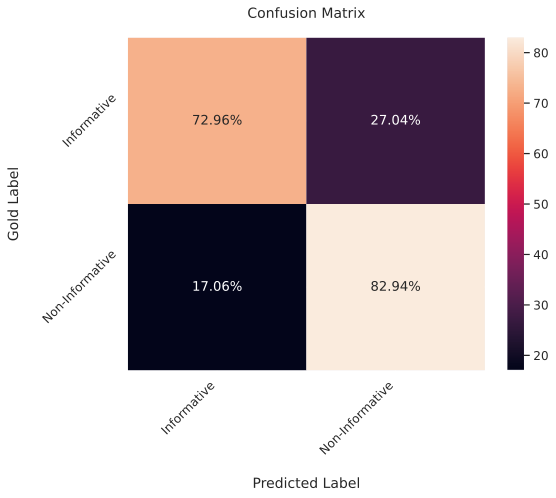

In [ ]:
# Showing the results of the best performing model
plot_cm_with_percentages(best_model_true_labels, best_model_predictions, mapping.keys(), name="informative_best")

In [ ]:
print(classification_report(best_model_true_labels,
                                  best_model_predictions,
                                  target_names=mapping.keys()))

                 precision    recall  f1-score   support

    Informative       0.69      0.73      0.71       980
Non-Informative       0.85      0.83      0.84      1870

       accuracy                           0.80      2850
      macro avg       0.77      0.78      0.78      2850
   weighted avg       0.80      0.80      0.80      2850



## The section below adds a custom classification layer on top of BERT embeddings

In [ ]:
# Next up, implement MLP
from torch import nn

In [ ]:
class CustomXLMRobertaClassification(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, combined_feat_dim):
      super().__init__()
      self.dense = nn.Linear(combined_feat_dim, combined_feat_dim)
      classifier_dropout = (
          config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
      )
      self.dropout = nn.Dropout(classifier_dropout)
      self.out_proj = nn.Linear(combined_feat_dim, config.num_labels)
      self.batch_norm = nn.BatchNorm1d(combined_feat_dim)

    def forward(self, x, **kwargs):
      # x = self.batch_norm(x)
      x = self.dropout(x)
      x = self.dense(x)
      x = torch.relu(x)
      x = self.dropout(x)
      x = self.out_proj(x)
      return x

In [ ]:
def test_this(test = False):
  if test == True:
    to_print = ("This is a true statement")
  print(to_print)

In [ ]:
test_this(True)

This is a true statement


In [ ]:
from torch import nn
from transformers import XLMRobertaForSequenceClassification
from torch.nn import CrossEntropyLoss, MSELoss

class BertConcatFeatures(XLMRobertaForSequenceClassification):

  def __init__(self, config):
    #BERT SETUP - calls the constructor for BertForSequenceClassification to
    # do the initial configuration - going to do all the BERT related setup.
    # The resulting BERT model is stored in `self.bert`.
    super().__init__(config)
    # Feature combination
    # Store the number of labels, which tells us whether this is a classification
    # or a regression task
    self.num_labels = config.num_labels
    # Calculate the combined vector length - CLS embedding + additional features
    # combined_feat_dim = config.text_feat_dim + config.context_feat_dim + config.numerical_feat_dim

    combined_feat_dim = config.text_feat_dim  + config.numerical_feat_dim

    # # Create a batch normalzier for the numerical features
    self.num_bn = nn.BatchNorm1d(config.numerical_feat_dim)

    # MLP Setup - specify the number of layers and neurons in each layer
    # Dimensions of each MLP layer
    dims = []
    # Starting with the combined feature vector length...
    dim = combined_feat_dim
    while True:

      #Divide by 4 and truncate to an interger
      dim = dim // 4
      # If the resulting later size would be smaller than the number of outpurs,
      # then we're done
      if dim <= self.num_labels:
        break
      #Otherise, store this as the next layer size
      dims.append(int(dim))

    # Print out the resulting the MLP
    print('MLP Layer sizes:')
    print(' Input:', combined_feat_dim)
    print(' Output:', self.num_labels)
    # Construct the MLP, specifying the number of inputs, outputs and the layer sizes
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.linear_classifier = nn.Linear(combined_feat_dim, config.num_labels)
    self.mlp = CustomXLMRobertaClassification(config, combined_feat_dim)

  def forward(
      self,
      input_ids=None,
      attention_mask=None,
      token_type_ids=None,
      position_ids=None,
      head_mask=None,
      inputs_embeds=None,
      labels = None,
      class_weights=None,
      output_attentions=None,
      output_hidden_states=None,
      # context_input_ids = None,
      # context_attention_mask = None,
      # context_token_type_ids = None,
      # context_position_ids = None,
      # context_head_mask = None,
      # context_inputs_embeds = None,
      # context_output_attentions = None,
      # context_output_hidden_states = None,
      numerical_feats=None,
      concat_context=False,
  ):

    # print("We are here --> does it even get here?")

    #Send text throught the BERT model
    outputs = self.roberta(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states
    )

    # if concat_context == True:
    #   # Send context through BERT model as well
    #   context_outputs = self.roberta(
    #       context_input_ids,
    #       attention_mask=context_attention_mask,
    #       token_type_ids=context_token_type_ids,
    #       position_ids=context_position_ids,
    #       head_mask=context_head_mask,
    #       inputs_embeds=context_inputs_embeds,
    #       output_attentions=context_output_attentions,
    #       output_hidden_states=context_output_hidden_states
    #   )

    #   context_output = context_outputs[0]
    #   context_cls = context_output[:, 0, :]
    #   context_cls = self.dropout(context_cls)

    # print("Are wee even here?")
    # Take the CLS embedding
    sequence_output = outputs[0]
    cls = sequence_output[:, 0, :]
    cls = self.dropout(cls)

    # print("We are here --> debugging")
    #Concatenate features
    # Apply batch normalization to the numerical features
    numerical_feats = numerical_feats.float()

    # if concat_context == True:
    #   combined_feats = torch.cat((cls, context_cls, numerical_feats), dim=1)

    # print("Is the problem coming from the combination?")
    #Simply concatenate everything into one vector
    combined_feats = torch.cat((cls, numerical_feats), dim=1)

    # Output classifier/regression
    logits = self.linear_classifier(combined_feats)

    if type(logits) is tuple:
      logits, classifier_layer_outputs = logits[0], logits[1]
    else:
      classifier_layer_outputs = [cls, logits]

    # Calculate loss
    if labels is not None:
      # Regression
      if self.num_labels == 1:
        loss_fct = MSELoss()
        labels = labels.float()
        loss = loss_fct(logits.view(-1), labels.view(-1))
      else:
        # print("Is the problem coming from cross entropy loss calculation?")
        loss_fct = CrossEntropyLoss(weight=class_weights, reduction='mean')
        labels = labels.long()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    else:
      loss = None

    # print("I'd laugh if we actually get here")
    results = {
        'loss': loss,
        'logits': logits,
        'classifier_layer_outputs': classifier_layer_outputs
    }

    return results

In [ ]:
from transformers import BertConfig

config = BertConfig.from_pretrained('xlm-roberta-base', num_labels=2)

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


In [ ]:
config.numerical_feat_dim = 6

In [ ]:
config.text_feat_dim = config.hidden_size

In [ ]:
config.context_feat_dim = config.hidden_size

In [ ]:
model = BertConcatFeatures.from_pretrained(
    'xlm-roberta-base',
    config = config
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing BertConcatFeatures: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing BertConcatFeatures from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertConcatFeatures from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertConcatFeatures were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['mlp.batch_norm.weight', 'num_bn.running_mean', 'linear_classifier.bias', 'num_bn.bias', 'num_bn.weight', 'num_

MLP Layer sizes:
 Input: 774
 Output: 2


In [ ]:
print('Loading model to GPU...')

# Connect to the GPU.
device = torch.device('cuda')

# Report what GPU we were granted.
print('  GPU:', torch.cuda.get_device_name(0))

# Copy the initial model weights to the GPU.
desc = model.to(device)

print('DONE.')

Loading model to GPU...
  GPU: NVIDIA A100-SXM4-40GB
DONE.


In [ ]:
batch_size = 32
learning_rate = 2e-5
epochs = 3

In [ ]:
def tokenize_with_numerical(sentences, labels, numerical_feats):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 300,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          truncation_strategy='only_first',
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  numerical_feats = torch.tensor(numerical_feats)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # # Print sentence 0, now as a list of IDs.
  # print('Original: ', sentences[0])
  # print('Token IDs:', input_ids[0])

  return input_ids, numerical_feats, attention_masks, labels

In [ ]:
def tokenize_context(sentences):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 256,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  # # Print sentence 0, now as a list of IDs.
  # print('Original: ', sentences[0])
  # print('Token IDs:', input_ids[0])

  return input_ids, attention_masks

In [ ]:
numerical_feats = ['election_distance_transformed', 'hour_cos', 'hour_sin','negative','neutral','positive']

In [ ]:
train_input_ids, train_numerical_feats, train_attention_masks, train_labels = tokenize_with_numerical(train_sentences, train_targets, train_data[numerical_feats].values)
val_input_ids, val_numerical_feats, val_attention_masks, val_labels = tokenize_with_numerical(val_sentences, val_targets, val_data[numerical_feats].values)
test_input_ids, test_numerical_feats, test_attention_masks, test_labels = tokenize_with_numerical(test_sentences, test_targets, test_data[numerical_feats].values)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [ ]:
train_context_input_ids, train_context_attention_masks = tokenize_context(train_contexts)
val_context_input_ids, val_context_attention_masks = tokenize_context(val_contexts)
test_context_input_ids, test_context_attention_masks = tokenize_context(test_contexts)

In [ ]:
len(train_numerical_feats[:])

9926

In [ ]:
from torch.utils.data.dataset import TensorDataset
train_dataset = TensorDataset(train_input_ids, train_numerical_feats, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_numerical_feats, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_numerical_feats, test_attention_masks, test_labels)

# train_dataset = TensorDataset(train_input_ids, train_numerical_feats, train_attention_masks, train_labels, train_context_input_ids, train_context_attention_masks)
# val_dataset = TensorDataset(val_input_ids, val_numerical_feats, val_attention_masks, val_labels, val_context_input_ids, val_context_attention_masks)
# test_dataset = TensorDataset(test_input_ids, test_numerical_feats, test_attention_masks, test_labels, test_context_input_ids, test_context_attention_masks)

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = batch_size

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = SequentialSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
val_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# # For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
labels = train_dataset[:][3].numpy()

In [ ]:
train_sentences[:1]

["Here at Oljoroorok we are still queuing to vote . So cold , raining and the queing officers are not doing their work .. [SEP] During the day , August 8 , 2017 , there were reported incidences of voter misinformation - that registered voters NOT in the area they were registered in would be allowed to vote in the presidential race at any polling station in the country . [SEP] 6 gas lamps are available #Awendo [SEP] Presiding officer captured all rejected ballot papers on form marked ‘ Rejected ' #KURIA EAST #MUTINITI"]

In [ ]:
labels

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
# Estimate the class weights to be used in the model training
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

In [ ]:
class_weights

tensor([1.4537, 0.7621], device='cuda:0')

In [ ]:
learning_rate

2e-05

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import random
import numpy as np
import time

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader),
                num_desired_updates = 10
            )

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update.
        if (step % update_interval) == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_numer_feats = batch[1].double().to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)
        # b_context_input_ids = batch[4].to(device)
        # b_context_input_mask = batch[5].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(input_ids=b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels = b_labels,
                       numerical_feats = b_numer_feats,
                       class_weights = class_weights)
                      #  context_input_ids = b_context_input_ids,
                      #  context_attention_mask = b_context_input_mask)

        loss = result['loss']
        logits = result['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_loss = 0


    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in val_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_numer_feats = batch[1].double().to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)
        # b_context_input_ids = batch[4].to(device)
        # b_context_input_mask = batch[5].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(input_ids=b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           class_weights = class_weights,
                           labels=b_labels,
                           numerical_feats = b_numer_feats)
                          #  context_input_ids = b_context_input_ids,
                          #  context_attention_mask = b_context_input_mask)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result['loss']
        logits = result['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Measure validation accuracy...

    # Combine the results across all batches.
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # For each sample, pick the label (0, 1, or 2) with the highest score.
    predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

    # Calculate the validation accuracy.
    val_accuracy = (predicted_labels == flat_true_labels).mean()

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


KeyboardInterrupt: ignored

In [ ]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.584356,0.521111,0.759431,0:02:03,0:00:05
2,0.481516,0.504370,0.785053,0:02:03,0:00:05


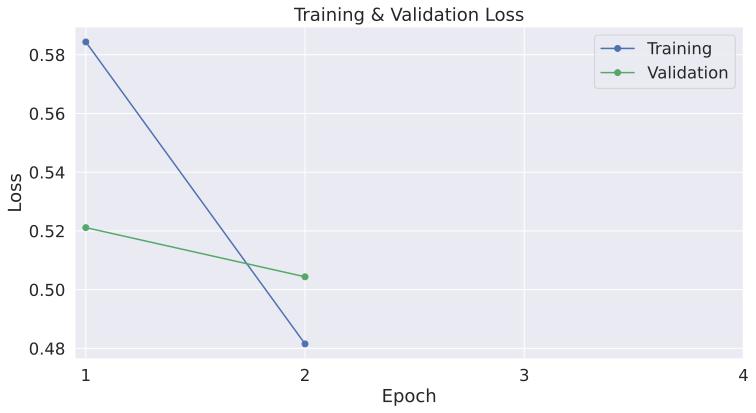

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_numerical_feats, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     numerical_feats = b_numerical_feats)

  logits = result['logits']

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE.')

DONE.


In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# # Calculate the MCC
# mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

# print('Total MCC: %.3f' % mcc)

print(classification_report(flat_true_labels,
                                flat_predictions,
                                target_names=mapping.keys()))

                 precision    recall  f1-score   support

    Informative       0.67      0.71      0.69       980
Non-Informative       0.84      0.81      0.83      1870

       accuracy                           0.78      2850
      macro avg       0.76      0.76      0.76      2850
   weighted avg       0.78      0.78      0.78      2850



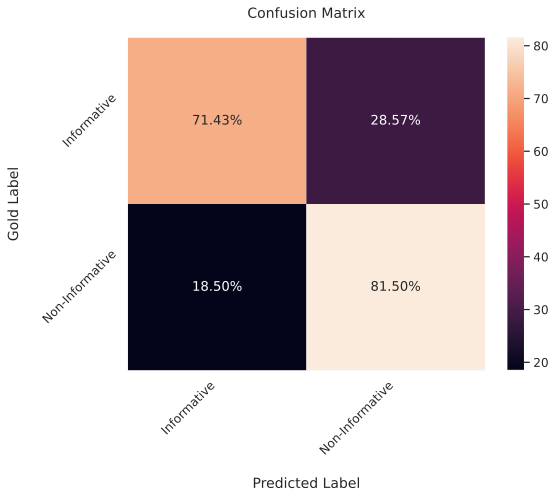

In [ ]:
plot_cm_with_percentages(flat_true_labels, flat_predictions, list(mapping.keys()))

In [ ]:
## Run the above models across multiple runs

In [ ]:
def train_custom_model(model, train_dataloader, epochs, class_weights, optimizer, scheduler):
  training_stats = []
  total_t0 = time.time()
  for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader),
                num_desired_updates = 10
            )
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_numer_feats = batch[1].double().to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)
        # b_context_input_ids = batch[4].to(device)
        # b_context_input_mask = batch[5].to(device)

        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels = b_labels,
                       numerical_feats = b_numer_feats,
                       class_weights = class_weights)
                      #  context_input_ids = b_context_input_ids,
                      #  context_attention_mask = b_context_input_mask)

        loss = result['loss']
        logits = result['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

In [ ]:
def test_custom_model(model,test_dataloader):
  # Put model in evaluation mode
  model.eval()
  # Tracking variables
  predictions , true_labels = [], []
  # Predict
  for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_numerical_feats, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      numerical_feats = b_numerical_feats)

    logits = result['logits']

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  return predictions, true_labels

In [ ]:
def run_and_test_fusion_multiple_times(no_of_runs=1, num_labels=5, epochs=4, train_dataloader = train_dataloader, test_dataloader= test_dataloader, class_weights=class_weights):
  results = {}
  for i in range(0, no_of_runs):
    # Init config
    config = BertConfig.from_pretrained('xlm-roberta-base', num_labels=num_labels)
    config.numerical_feat_dim = 6
    config.text_feat_dim = config.hidden_size
    # config.context_feat_dim = config.hidden_size

    # Initialize model and load it to device every single time
    model = BertConcatFeatures.from_pretrained(
    'xlm-roberta-base',
    config = config
    )
    # Move model to device
    desc = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
                )

    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)
    # Measure the total training time for the whole run.
    total_t0 = time.time()
    print(f"Training Current run: {i+1}")
    train_custom_model(model, train_dataloader, epochs, class_weights, optimizer, scheduler)
    print(f"Testing Current run: {i+1}")
    # Test model on test set
    predictions, true_labels = test_custom_model(model, test_dataloader)
    results[f"Run {i+1}"] = (predictions, true_labels)
  return results

In [ ]:
results = run_and_test_fusion_multiple_times(no_of_runs=5, epochs=3, num_labels=2)

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing BertConcatFeatures: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing BertConcatFeatures from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertConcatFeatures from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertConcatFeatures were not initialized from the model checkpoint at 

MLP Layer sizes:
 Input: 774
 Output: 2
Training Current run: 1

======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.59
  Training epoch took: 0:02:03

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.48
  Training epoch took: 0:02:03

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.42
  Training epoch took: 0:02:03
Testing Current run: 1


You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


MLP Layer sizes:
 Input: 774
 Output: 2


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing BertConcatFeatures: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing BertConcatFeatures from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertConcatFeatures from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertConcatFeatures were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['mlp.batch_norm.weight', 'num_bn.running_mean', 'linear_classifier.bias', 'num_bn.bias', 'num_bn.weight', 'num_

Training Current run: 2

======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.56
  Training epoch took: 0:02:03

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.47
  Training epoch took: 0:02:03

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.40
  Training epoch took: 0:02:03
Testing Current run: 2


You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing BertConcatFeatures: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing BertConcatFeatures from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertConcatFeatures from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertConcatFeatures were not initialized from the model checkpoint at 

MLP Layer sizes:
 Input: 774
 Output: 2
Training Current run: 3

======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.56
  Training epoch took: 0:02:03

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.47
  Training epoch took: 0:02:03

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.41
  Training epoch took: 0:02:03
Testing Current run: 3


You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing BertConcatFeatures: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing BertConcatFeatures from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertConcatFeatures from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertConcatFeatures were not initialized from the model checkpoint at 

MLP Layer sizes:
 Input: 774
 Output: 2
Training Current run: 4

======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.55
  Training epoch took: 0:02:03

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.47
  Training epoch took: 0:02:03

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.41
  Training epoch took: 0:02:03
Testing Current run: 4


You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing BertConcatFeatures: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing BertConcatFeatures from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertConcatFeatures from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertConcatFeatures were not initialized from the model checkpoint at 

MLP Layer sizes:
 Input: 774
 Output: 2
Training Current run: 5

======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.55
  Training epoch took: 0:02:03

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.46
  Training epoch took: 0:02:03

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.40
  Training epoch took: 0:02:03
Testing Current run: 5


In [ ]:
# Print out the average results
# Save the results to a csv or something of the sort

In [ ]:
(best_model_predictions, best_model_true_labels), macro_f1_score, avg_report = average_classification_report(results, target_names=mapping.keys())

In [ ]:
print(macro_f1_score)

0.7637750422851963


In [ ]:
results_df = pd.DataFrame.from_dict(avg_report)

In [ ]:
results_df.to_csv('/content/drive/My Drive/thesis/informative_types_averaged_results_with_custom_features.csv')

In [ ]:
plot_cm_with_percentages(best_model_true_labels, best_model_predictions, mapping.keys(), name="informative_averaged_results")

NameError: ignored

In [ ]:
print(classification_report(best_model_true_labels, best_model_predictions, target_names=mapping.keys()))

                 precision    recall  f1-score   support

    Informative       0.68      0.76      0.72       980
Non-Informative       0.86      0.82      0.84      1870

       accuracy                           0.80      2850
      macro avg       0.77      0.79      0.78      2850
   weighted avg       0.80      0.80      0.80      2850



In [ ]:
# STUDY 3: Model Evaluation across language groups

In [ ]:
# Code to save the models

In [ ]:
# Save the model
model_path = "/content/drive/My Drive/thesis/models/"
model.save_pretrained(model_path)

print("Model saved successfully!")

In [ ]:
# Split the testdataset according to language and then compare the results across the different language groups
# English and swahili posts

In [ ]:
print(test_data.shape)

(1418, 20)


In [ ]:
test_data.head()

,text,clean_text,normalized_text,merged_label,label,status,Election Date,date,informative_label,election_distance,election_distance_abs,hour,hour_sin,hour_cos,informative_target,context,election_distance_transformed,negative,neutral,positive
0,Nope. We have refused to bleed so that your leader can lead. This thing is done and dusted. P.O.R.K is the one declared yesterday and gazetted by iebc today. Take this info to your safest safe.,nope we have refused bleed so that your leader can lead this thing done and dusted k the one declared yesterday and gazetted by iebc today take this info your safest safe,Nope . We have refused to bleed so that your leader can lead . This thing is done and dusted . P . O . R . K is the one declared yesterday and gazetted by iebc today . Take this info to your safest safe .,Other,Opinions,draft,August 2022,2022-08-16 20:56:28,Non-Informative,-8,8,20,-0.866025,0.500000,1,"We have 47 universities in Kenya teaching Statistics and Actuarial Science yet only 2 people were interested to analyze the IEBC numbers . We have 69 Universities in Kenya teaching computer science YET i haven't seen any App or Websites reporting & analyzing IEBC numbers [SEP] "" Once the game is settled the winner is comfortable and can govern while the loser is satisfied that they got a fair determination of that loss . "" - Davis Tayo #KenyanElection2022 #KenyaDecides [SEP] How do Kenyans vote for such people ? Some people are idiots for leaders . The 0.0 % | The 4 | IEBC Commissioners | Junet Mohamed | Babu Owino [SEP]",0.678152,0.222685,0.271114,0.506201
1,Democracy ensures Societal equality. It is your right to vote Practice it. Wishing Us a peaceful election ahead.\n#KenyaDecides2022 #Iebc #KenyansPoll #Democracy,democracy ensures societal equality it your right vote practice it wishing peaceful election ahead kenyadecides iebc kenyanspoll democracy,Democracy ensures Societal equality . It is your right to vote Practice it . Wishing Us a peaceful election ahead . #KenyaDecides2022 #Iebc #KenyansPoll #Democracy,Other,Opinions,published,August 2022,2022-08-09 05:10:34,Non-Informative,-1,1,5,0.965926,0.258819,1,"Fellow Kenyans , VOTE PEACE ! Mind your Tomorrow , . Peace s the only Constant ! Don't panic ! #kenyadecides #kenyadecides2022 #peacefulelection #peacefulElections #votepeace #votepeace2022 #kenyakwanza #azimiolaumoja #wajackoyahthe5th #babanamartha #williamruto [SEP] "" Tumekaa hapa kutoka saa nne usiku tukitegea IEBC ifungue , ” ( We have been heresince 4am waiting for IEBC to open . "" Kisumu residents spent night at polling station #KURA2022 [SEP] I'll be showing my Kenyanness by voting at 5pm in the evening . IEBC must ensure that they extend the deadline . #KenyansPoll [SEP]",0.529530,0.906834,0.074995,0.018171
2,I have never been shocked as much as I have been shocked by the IEBC Madam who started giving a press statement in Serena. The next thing I thought would happen was a Military Takeover. Wah!,have never been shocked as much as have been shocked by the iebc madam who started giving press statement in serena the next thing thought would happen was military takeover wah,I have never been shocked as much as I have been shocked by the IEBC Madam who started giving a press statement in Serena . The next thing I thought would happen was a Military Takeover . Wah !,Other,Opinions,published,August 2022,2022-08-15 17:18:58,Non-Informative,-7,7,17,-0.965926,-0.258819,1,This is the official position of Dr . OBURU OGINGA ... I am confident that Raila Odinga Has won this election with 51 % . Kenyans let us be calm as we await the announcement of the president-elect HON . ENG . RAILA AMOLLO ODINGA . [SEP] I can't accept what IEBC was declared [SEP] Kenyans will disappoint all international press by remaining peaceful . [SEP],0.665165,0.386501,0.578161,0.035338
3,"You cannot interfere with the numbers in the IEBC portal Form 34As. Stop intimidating Returning Officers and distracting IEBC, just write a concession letter si

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=8f725ebb28389f5d21c23a5494baad9c7e0e0bb594c4a2ae154d183543dbf062
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
from langdetect import detect
from langdetect import detect_langs

In [ ]:
detect("Turnout Leo Iko very low . Sioni wakifika 15M")

'sw'

In [ ]:
test_data['lang'] = test_data['normalized_text'].map(detect)

In [ ]:
test_data['lang'].unique()

array(['en', 'it', 'sw', 'de', 'id', 'pt', 'af', 'ca', 'fr', 'no', 'ro',
       'tl', 'hr', 'nl', 'et'], dtype=object)

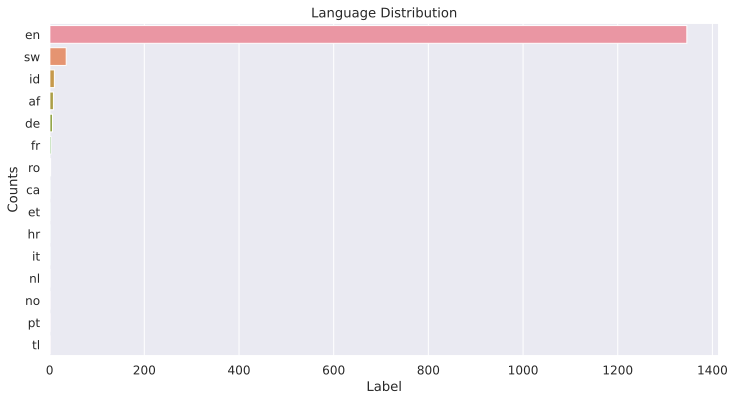

In [ ]:
grouped_counts = test_data.groupby("lang").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='lang')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Language Distribution')
plt.show()

In [ ]:
model_data['lang'] = model_data['normalized_text'].map(detect)

In [ ]:
from transformers import pipeline

In [ ]:
dvc = 0 if torch.cuda.is_available() else -1

In [ ]:
model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt, device=dvc)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
model_preds = [s['label'] for s in pipe(model_data.normalized_text.values.tolist(), truncation=True, max_length=128)]

In [ ]:
len(model_preds)

14180

In [ ]:
model_data['lang'] = model_preds

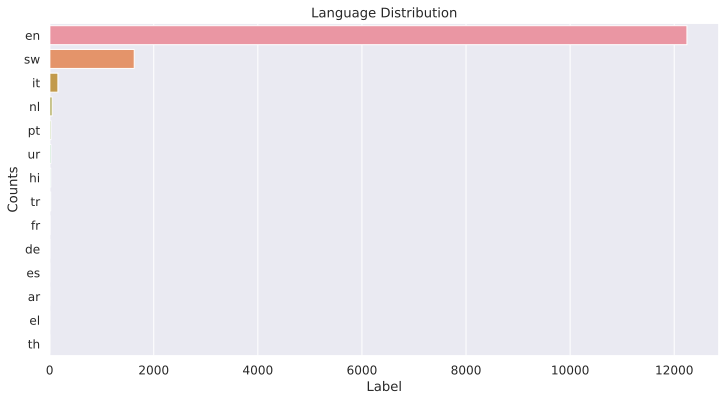

In [ ]:
grouped_counts = model_data.groupby("lang").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='lang')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Language Distribution')
plt.show()

In [ ]:
model_data['detect_lang'] = model_data['clean_text'].map(detect)

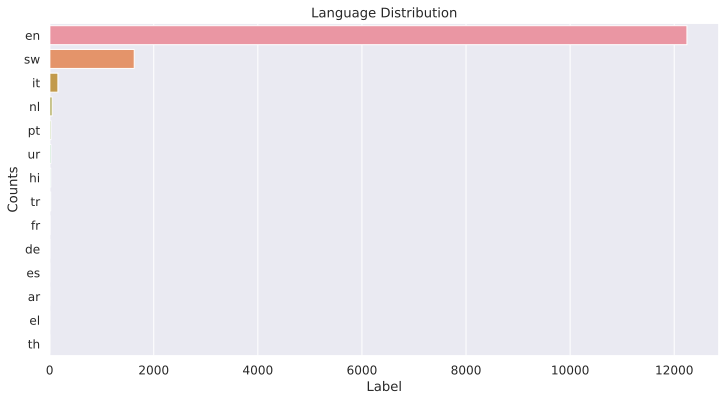

In [ ]:
grouped_counts = model_data.groupby("lang").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='lang')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Language Distribution')
plt.show()

In [ ]:
# Seeems like the finetuned XLM-Roberta for language identification is able to identify more swahili posts

In [ ]:
model_data[model_data['lang'] != 'en'].shape

(1936, 16)

In [ ]:
model_data[model_data['lang'] != 'en'].sample(10)

,text,clean_text,normalized_text,merged_label,label,status,Election Date,date,informative_label,election_distance,election_distance_abs,hour,hour_sin,hour_cos,lang,detect_lang
4598,"enyewe watu wa Azimio wote ni wajinga. Iebc gave the company the tender of digital transmission platform for the election & for it to work the company sent there team to set up,test and hand over to iebc before election only for them to be arrested. Go read the statement by iebc",enyewe watu wa azimio wote ni wajinga iebc gave the company the tender of digital transmission platform for the election for it work the company sent there team set up test and hand over iebc before election only for them be arrested go read the statement by iebc,"enyewe watu wa Azimio wote ni wajinga . Iebc gave the company the tender of digital transmission platform for the election & for it to work the company sent there team to set up , test and hand over to iebc before election only for them to be arrested . Go read the statement by iebc",Security Issues,Security Issues,published,August 2022,2022-07-22 20:42:12,Informative,17,17,20,-8.660254e-01,5.000000e-01,sw,en
7929,"William Samoei Ruto - The 5th. \n9th August, ngware tumalize hii bizness and focus on the economy. \n\n#KenyaDecides #Ruto #GE2022 #The5th",william samoei ruto the august ngware tumalize hii bizness and focus the economy kenyadecides ruto ge theth,"William Samoei Ruto - The 5th . 9th August , ngware tumalize hii bizness and focus on the economy . #KenyaDecides #Ruto #GE2022 #The5th",Other,Opinions,published,August 2022,2022-08-01 11:45:45,Non-Informative,7,7,11,2.588190e-01,-9.659258e-01,sw,en
7997,Raila to be sworn in as president,raila be sworn in as president,Raila to be sworn in as president,Other,Opinions,published,August 2022,2022-08-01 13:46:05,Non-Informative,7,7,13,-2.588190e-01,-9.659258e-01,nl,en
13353,"The latest presidential results updates #KenyaDecides UHURU KENYATTA: 8 062 422 votes (54,28%), RAILA ODINGA 6 660 348 votes (44,84%)",the latest presidential results updates kenyadecides uhuru kenyatta votes raila odinga votes,"The latest presidential results updates #KenyaDecides UHURU KENYATTA : 8 062 422 votes ( 54,28 % ) , RAILA ODINGA 6 660 348 votes ( 44,84 % )",Counting and Results,Counting and Results,published,August 2017,2017-08-10 10:00:02,Informative,-2,2,10,5.000000e-01,-8.660254e-01,sw,et
11929,Mimi nitajitokeza waziwazi mapema na kumchagua kiongozi wangu wa maendeleo na umoja. Pamoja twaweza!!,mimi nitajitokeza waziwazi mapema na kumchagua kiongozi wangu wa maendeleo na umoja pamoja twaweza,Mimi nitajitokeza waziwazi mapema na kumchagua kiongozi wangu wa maendeleo na umoja . Pamoja twaweza ! !,Positive Events,Positive Events,archived,August 2017,2017-08-08 04:37:23,Informative,0,0,4,8.660254e-01,5.000000e-01,sw,sw
10504,"Fellow Kenyans, VOTE PEACE!\nMind your Tomorrow,. Peace s the only Constant! Don't panic! \n\n#kenyadecides #kenyadecides2022 #peacefulelection #peacefulElections #votepeace #votepeace2022 #kenyakwanza #azimiolaumoja #wajackoyahthe5th #babanamartha #williamruto",fellow kenyans vote peace mind your tomorrow peace the only constant don panic kenyadecides kenyadecides peacefulelection peacefulelections votepeace votepeace kenyakwanza azimiolaumoja wajackoyahtheth babanamartha williamruto,"Fellow Kenyans , VOTE PEACE ! Mind your Tomorrow , . Peace s the only Constant ! Don't panic ! #kenyadecides #kenyadecides2022 #peacefulelection #peacefulElections #votepeace #votepeace2022 #kenyakwanza #azimiolaumoja #wajackoyahthe5th #babanamartha #williamruto",Other,Opinions,published,August 2022,2022-08-09 03:19:25,Non-Informative,-1,1,3,7.071068e-01,7.071068e-01,sw,en
12536,No problem untill now#cherenganyi,no problem untill nowcherenganyi,No problem untill now #cherenganyi,Positive Events,Positive Events,published,August 2017,2017-08-08 11:06:24,Informative,0,0,11,2.588190e-01,-9.659258e-01,sw,en
7464,Raila demand answers on extra IEBC forms\nhttps://bit.ly/3cNck5E\n@Raila

In [ ]:
# Get the test and validation data languages
test_data['lang'] = [s['label'] for s in pipe(test_data.clean_text.values.tolist(), truncation=True, max_length=128)]

In [ ]:
val_data['lang'] = [s['label'] for s in pipe(val_data.clean_text.values.tolist(), truncation=True, max_length=128)]

In [ ]:
print(test_data[test_data['lang'] != 'en'].shape, val_data[val_data['lang'] != 'en'].shape)

(490, 21) (500, 21)


In [ ]:
non_english_test_data = test_data[test_data['lang'] != 'en']

In [ ]:
non_english_val_data = val_data[val_data['lang'] != 'en']

In [ ]:
non_english_test_data.sample(5)

,text,clean_text,normalized_text,merged_label,label,status,Election Date,date,informative_label,election_distance,...,hour,hour_sin,hour_cos,informative_target,context,election_distance_transformed,negative,neutral,positive,lang
707,IEBC chair Chebukati opted out of National Multi-Sectoral Consultative Forum (NMSCF) and the Technical Working Committee (TWC) on Election Preparedness. led by Kibicho and Mucheru\nThe deep state wanted to take full charge of elections\nMucheru once told us to vote and go home,iebc chair chebukati opted out of national sectoral consultative forum nmscf and the technical working committee twc election preparedness led by kibicho and mucheru the deep state wanted take full charge of elections mucheru once told vote and go home,IEBC chair Chebukati opted out of National Multi-Sectoral Consultative Forum ( NMSCF ) and the Technical Working Committee ( TWC ) on Election Preparedness . led by Kibicho and Mucheru The deep state wanted to take full charge of elections Mucheru once told us to vote and go home,Other,Opinions,published,August 2022,2022-07-24 06:55:52,Non-Informative,15,...,6,1.000000e+00,6.123234e-17,1,"This push na pull between IEBC vs DCI and NPS has reminded me of this woman defending Chebukati . Her tonal variations and expressions [SEP] The unfolding spat between the electoral agency , IEBC , and the Police over the arrest of the election officials is a clear show of how the government is determined to interfere with the August 9th elections . [SEP] Chebukati the man is putting us the voters in an worrying situation , he's playing with Kenyan lives . [SEP]",0.899399,0.041608,0.114340,0.844052,sw
679,"Our Man Dennis Itumbi has given us Finals of Presidential Election Result on HNIB Center, Nairobi.\nWilliam Ruto has garnered 51.39&\nRaila Odinga has garnered 48.11%\nH.E @WilliamsRuto the 5th",our man dennis itumbi has given finals of presidential election result hnib center nairobi william ruto has garnered raila odinga has garnered the,"Our Man Dennis Itumbi has given us Finals of Presidential Election Result on HNIB Center , Nairobi . William Ruto has garnered 51.39 & Raila Odinga has garnered 48.11 % H . E @USER the 5th",Counting and Results,Counting and Results,draft,August 2022,2022-08-11 02:23:37,Informative,-3,...,2,5.000000e-01,8.660254e-01,0,"At this point I'm not sure media houses have an actual tally workforce ... They'll just i + + and x + = 1 random numbers until IEBC comes out with the final results . [SEP] Joseph Cherorot of the UDA party Wins the Kipkelion East MP by garnering 36,066 votes to beat the incumbent Joseph Limo who garnered 11,268 votes . #IEBC #KenyaDecides2022 [SEP] The weakest link in Kenya's elections is IEBC . It is time we demanded value for money from this institution . Kenya's elections at Kshs 2,500 per head compared to the Indian ones at Kshs 65 per head are among the most expensive on earth . @USER [SEP]",0.569069,0.086845,0.823308,0.089847,sw
1155,"What the Hell is this!!......NTV, KTN, CITIZEN TV, K24 and ITUMBI ,jeovah wanyonyi TALLYING CENTRE all transmitting Different results for both Raila and Ruto......the IEBC must act and act fast to stabilize results capture......is someone listening??",what the hell this ntv ktn citizen tv k and itumbi jeovah wanyonyi tallying centre all transmitting different results for both raila and ruto the iebc must act and act fast stabilize results capture someone listening,"What the Hell is this ! ! ... NTV , KTN , CITIZEN TV , K24 and ITUMBI , jeovah wanyonyi TALLYING CENTRE all transmitting Different results for both Raila and Ruto ... the IEBC must act and act fast to stabilize results capture ... is someone listening ? ?",Counting and Results,Counting and Results,archived,August 2022,2022-08-10 13:30:51,Informative,-2,...,13,-2.588190e-01,-9.659258e-01,0,"With only 160 34As per constituency on average , if theres ten of you , thats only 16 per person . It should take you no more than an hour . We should be don

In [ ]:
tests = ["according the independent electoral and boundaries commission the information about missing kenya integrated electoral management system kits false and misleading"]

In [ ]:
model_preds = [s['label'] for s in pipe(tests, truncation=True, max_length=128)]

In [ ]:
model_preds

['en']

In [ ]:
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

# Util functions for cleaning the data
def replace_newline(text):
    '''
        Replace all occurences of new line delimeter in the text with space
    '''
    cleaned_text = text.replace("\n", " ")
    return cleaned_text

# Remove unicode
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

# Replacing URLs
def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

# Replace user mentions e.g. @
def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','usr',text)
    return text

# Remove hashtags infront of words
def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replace_numbers(text):
    cleaned_text = re.sub(r'[0-9]', '', text)
    return cleaned_text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

def remove_punctuation(text):
    # Remove punctuation between words
    text = re.sub(r'(\w)([^\w\s]+)(?=\w)', r'\1 \2 ', text)
    # Remove remaining punctuation
    text = re.sub(r'[^\w\s]', '', text)
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def lower_case(text):
    # remove newline and tab characters
    text = text.replace("\n","").replace("\t","")
    # strip whitespace
    text = text.strip()
    # lowercase
    text = text.lower()
    return text

def remove_stopwords(text, tokenizer, stop_words):
     # Tokenize the text into words
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # #     # Lemmatize words
    # lemmatizer = WordNetLemmatizer()
    # cleaned_text = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # stemmer = PorterStemmer()
    # cleaned_text = [stemmer.stem(word) for word in filtered_tokens]

    # Join the cleaned tokens back into a single string
    cleaned_text = ' '.join(filtered_tokens)
    return cleaned_text

def remove_twitter_hashtags(text):
  # Regular expression pattern to match Twitter hashtags
  hashtag_pattern = re.compile(r'#\w+')

  # Remove hashtags from the text
  text_without_hashtags = re.sub(hashtag_pattern, '', text)

  return text_without_hashtags

def clean_text(text, tokenizer, stop_words):
    text = replace_newline(text)
    text = removeUnicode(text)
    text = replace_numbers(text)
    text = remove_twitter_hashtags(text)
    text = replaceURL(text)
    text = replaceAtUser(text)
    text = removeEmoticons(text)
    text = replaceMultiExclamationMark(text)
    text = replaceMultiQuestionMark(text)
    text = replaceMultiStopMark(text)
    text = remove_punctuation(text)
    text = lower_case(text)
    # text = remove_stopwords(text, tokenizer, stop_words)
    return text

In [ ]:
test_samples = list(model_data['text'].sample(5))
test_samples

['Traffic moving in the opposite direction @ outering rd',
 'Day 2 Youth Peace & Voter Education Training,themed being Cascading Voter & peace education to the village level.Young people are not only going to help communities in voter education but preach & maintain peace.',
 'Beefing up security here is a euphemism for State preparation to unleash even more lethal force and State violence… https://t.co/iL4RPbf7JY',
 'says the stability of the country depends on how electoral agency will manage the election.',
 'Citizens w/whistles in strongholds going to doors since 4am waking neighbors to get up &amp; vote in #ElectionsKE\n#KenyaDecides\n#ElectionsKE2017']

In [ ]:
stoplist = stopwords.words('english')
my_stopwords = "usr url atuser st rd nd th am pm num multiexclamation multiquestion multistop" # my extra stopwords
stoplist = stoplist + my_stopwords.split()
tokenizer = TweetTokenizer()

In [ ]:
for text in test_samples:
    print(clean_text(text, tokenizer, my_stopwords) + "\n")

traffic moving in the opposite direction  outering rd

day  youth peace  voter education training  themed being cascading voter  peace education to the village level  young people are not only going to help communities in voter education but preach  maintain peace

beefing up security here is a euphemism for state preparation to unleash even more lethal force and state violence url

says the stability of the country depends on how electoral agency will manage the election

citizens w  whistles in strongholds going to doors since am waking neighbors to get up amp vote in



In [ ]:
model_data["clean_text"] = model_data["text"].apply(lambda text: clean_text(text, tokenizer, my_stopwords))

In [ ]:
model_data['lang'] = [s['label'] for s in pipe(model_data.clean_text.values.tolist(), truncation=True, max_length=128)]

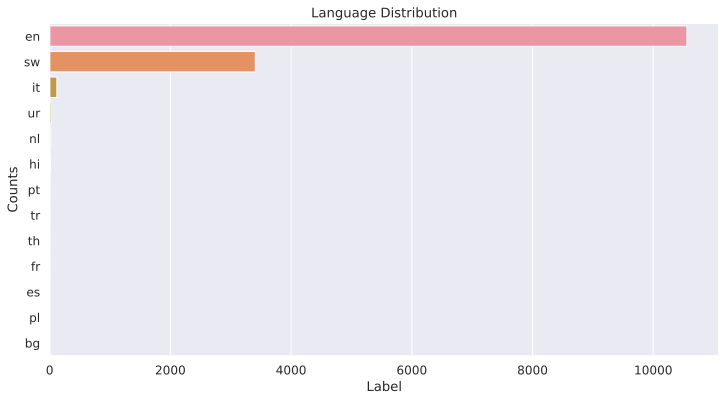

In [ ]:
grouped_counts = model_data.groupby("lang").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='lang')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Language Distribution')
plt.show()

In [ ]:
model_data[model_data['lang'] != 'en'].sample(10)

,text,clean_text,normalized_text,merged_label,label,status,Election Date,date,informative_label,election_distance,election_distance_abs,hour,hour_sin,hour_cos,lang,detect_lang
7125,Buffalo GANG ??? \n\nMACHAKOS COUNTY will NOT be CONTROLLED and MISLED by a GANG of POLITICAL REJECTS !!!\n\nMASAKU | IEBC | Chebukati | Azimio | Raila | Baba | Kalonzo | Wavinya | Maliti | Yvonne | Magoha | Nairobi | Mombasa | Kenyans |,buffalo gang multiquestion machakos county will not be controlled and misled by a gang of political rejects multiexclamation masaku iebc chebukati azimio raila baba kalonzo wavinya maliti yvonne magoha nairobi mombasa kenyans,Buffalo GANG ? ? ? MACHAKOS COUNTY will NOT be CONTROLLED and MISLED by a GANG of POLITICAL REJECTS ! ! ! MASAKU | IEBC | Chebukati | Azimio | Raila | Baba | Kalonzo | Wavinya | Maliti | Yvonne | Magoha | Nairobi | Mombasa | Kenyans |,Other,Opinions,published,August 2022,2022-07-28 04:50:19,Non-Informative,11,11,4,0.866025,5.000000e-01,sw,tl
9271,IEBC Committee cancels Eric Basweti’s nomination for MCA Bomwagamo ward,iebc committee cancels eric baswetis nomination for mca bomwagamo ward,IEBC Committee cancels Eric Basweti's nomination for MCA Bomwagamo ward,Other,Opinions,published,August 2022,2022-08-03 15:28:53,Non-Informative,5,5,15,-0.707107,-7.071068e-01,sw,en
109,"Mutahi Ngunyi\n·\nAug 15, 2022\n@MutahiNgunyi\n·\nFollow\nChebukati had until TUESDAY. One MORE DAY as per the constitution. WHY hurry? Why ANNOUNCE results before the COMMISSION had CONSENSUS? Why did the DIPLOMATS walk OUT?",mutahi ngunyi aug usr follow chebukati had until tuesday one more day as per the constitution why hurry why announce results before the commission had consensus why did the diplomats walk out,"Mutahi Ngunyi · Aug 15 , 2022 @USER · Follow Chebukati had until TUESDAY . One MORE DAY as per the constitution . WHY hurry ? Why ANNOUNCE results before the COMMISSION had CONSENSUS ? Why did the DIPLOMATS walk OUT ?",Other,Opinions,published,August 2022,2022-08-15 23:12:55,Non-Informative,-7,7,23,-0.258819,9.659258e-01,sw,en
13319,Kudos to Langata MP elect Generali Nickson korir. #KenyaDecides,kudos to langata mp elect generali nickson korir,Kudos to Langata MP elect Generali Nickson korir . #KenyaDecides,Other,Other,draft,August 2017,2017-08-10 07:30:03,Non-Informative,-2,2,7,0.965926,-2.588190e-01,sw,id
5530,Ruto +Chebukati have been caught pants down. panicking they are speaking the same language.\nFinally the owner of Chebukati Ruto replies the DCI on behalf of IEBC\nRuto = Chebukati \nDeepstate at work. Jela iko,ruto chebukati have been caught pants down panicking they are speaking the same language finally the owner of chebukati ruto replies the dci on behalf of iebc ruto chebukati deepstate at work jela iko,Ruto + Chebukati have been caught pants down . panicking they are speaking the same language . Finally the owner of Chebukati Ruto replies the DCI on behalf of IEBC Ruto = Chebukati Deepstate at work . Jela iko,Other,Opinions,published,August 2022,2022-07-24 20:19:20,Non-Informative,15,15,20,-0.866025,5.000000e-01,sw,en
12820,"Odinga _182 , Kenyatta _109 , Nyaga _3 ,Aukot _ 2 , others _0 . valid. _296 , rejected. _ 4 ,strays _1 . total vote _301 President ial results#Cherenganyi",odinga kenyatta nyaga aukot others valid rejected strays total vote president ial results,"Odinga _182 , Kenyatta _109 , Nyaga _3 , Aukot _ 2 , others _0 . valid . _296 , rejected . _ 4 , strays _1 . total vote _301 President ial results #Cherenganyi",Counting and Results,Counting and Results,archived,August 2017,2017-08-08 16:26:33,Informative,0,0,16,-0.866025,-5.000000e-01,sw,en
5831,"Kenya Kwanza isn't ready to allow Independence of IEBC be interfered by Kuzimia group and state machinery, Let Chebukati to do his work to ensure election is held free and fair",kenya kwanza isn t ready to allow independence of iebc be interfered by kuzimia group and state machinery let chebukati to do his work to ensure election is held free and 

In [ ]:
test_data['lang'] = [s['label'] for s in pipe(test_data.clean_text.values.tolist(), truncation=True, max_length=128)]

In [ ]:
test_data['detect_lang'] = test_data['clean_text'].map(detect)

In [ ]:
test_data[test_data['lang'] != 'en'].head()

,text,clean_text,normalized_text,merged_label,label,status,Election Date,date,informative_label,election_distance,...,hour_sin,hour_cos,informative_target,context,election_distance_transformed,negative,neutral,positive,lang,detect_lang
6,"Whilst at the campaigns they addressed several issues which they claim Jubilee have miserably failed to achieve. Raila, Uhuru Kenyatta,Senator Boni Khalwale",whilst the campaigns they addressed several issues which they claim jubilee have miserably failed achieve raila uhuru kenyatta senator boni khalwale,"Whilst at the campaigns they addressed several issues which they claim Jubilee have miserably failed to achieve . Raila , Uhuru Kenyatta , Senator Boni Khalwale",Political Rallies,Political Rallies,published,August 2017,2017-08-06 09:13:28,Informative,2,...,7.071068e-01,-0.707107,0,"Uhuru Kenyatta led "" Uhuruto Express "" in securing voted in the county [SEP] Deputy President William Ruto led Jubilee campaigns in Tana River and Kilifi counties , challenging the opposition to come out clear on their agenda for the people , accusing them of confusing the public with two manifestos , while defending jubilees track record and urging residents to allow them to continue their development agenda . [SEP] Pokomo council of elders ( GASA ) publicly endorsed Tana River governorship aspirant Maj ( rtd ) Godhana , along with his running mate , Kea Batuyu Salim , senate aspirant Michael Nkaduda , Garsen Parliamentary aspirant Aliway Komora , Galole Parliamentary aspirant Said Hiribae and Woman Representative aspirant Rehema Namas . [SEP]",0.546547,0.061147,0.688925,0.249928,sw,en
9,Aspirants for various elective seats in Murang'a including @Belive_Kinuthia and @Ruiru_benard joined us today to convey a message to the youth in Muranga that peace during elections is our responsibility.\n\n@FNF_EastAfrica \n@NYC_YouthVoice\n#FormNiKuvote #MbogiYaAmani #GE2022,aspirants for various elective seats in murang including and joined today convey message the youth in muranga that peace during elections our responsibility formnikuvote mbogiyaamani ge,Aspirants for various elective seats in Murang'a including @USER and @USER joined us today to convey a message to the youth in Muranga that peace during elections is our responsibility . @USER @USER #FormNiKuvote #MbogiYaAmani #GE2022,Positive Events,Positive Events,published,August 2022,2022-07-16 12:26:56,Informative,23,...,1.224647e-16,-1.000000,0,"Our future is in the hands of the very 200,000 people who shouldn't have the vote . [SEP] We're taking the lead as the Youth on matter's leadership and Election's as we foster Peace around the Country during and after the election ! @USER @USER @USER @USER @USER #UchaguziWaAmani [SEP] With brothers @USER @USER and the young man who need to be stopped @USER how can you throw a gang sign in a corporate photo Isiolo fully represented at the Youth peace and voter education training ongoing @USER #UchaguziWaAmani [SEP]",0.981481,0.872473,0.115083,0.012444,sw,en
14,Jubilee certificate issuance to Wanjiku Muhia in favour of Faith Gitau,jubilee certificate issuance wanjiku muhia in favour of faith gitau,Jubilee certificate issuance to Wanjiku Muhia in favour of Faith Gitau,Political Rallies,Political Rallies,published,August 2017,2017-08-06 07:23:38,Informative,2,...,9.659258e-01,-0.258819,0,"a ) Scorned the Inspector General of police over the apprehensions of its new polling stations strategies . b ) Demanded for the publication of the Voter Register by the IEBC c ) Mentioned the plans to provide free education from Nursery to Secondary school starting from 1st September [SEP] Jubilee Gubenatorial , women representative and senatorial , Mike Sonko , Rachel Shebesh , Sakaja Johnson respectively , held Caravan Campaigns in Nairobi estates pipeline , imara daima and embakasi [SEP] The Nasa leaders , led by presidential candidate Raila Odinga , called for a huge turnout on election day on Tuesday , but urged vigilance on the vote co

In [ ]:
english_test = test_data[test_data['detect_lang'] == 'en']

In [ ]:
non_english_test = test_data[test_data['detect_lang'] != 'en']

In [ ]:
non_english_test.shape

(90, 22)

In [ ]:
english_test_informative = english_test[english_test['informative_label'] == 'Informative']
english_test_informative.shape

(450, 22)

In [ ]:
non_english_test_informative = non_english_test[non_english_test['informative_label'] == 'Informative']
non_english_test_informative.shape

(44, 22)

In [ ]:
# english_test_informative.head()

In [ ]:
english_test_informative["target"] = inf_labeller.transform(english_test_informative["merged_label"])
non_english_test_informative["target"] = inf_labeller.transform(non_english_test_informative["merged_label"])

<ipython-input-160-97b7bebe5aa8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_test_informative["target"] = inf_labeller.transform(english_test_informative["merged_label"])
<ipython-input-160-97b7bebe5aa8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_english_test_informative["target"] = inf_labeller.transform(non_english_test_informative["merged_label"])


In [ ]:
english_test_sentences, english_test_targets = combine_features(english_test_informative)

Combining features into strings...
  DONE.
Dataset contains 450 samples.


In [ ]:
non_english_test_sentences, non_english_test_targets = combine_features(non_english_test_informative)

Combining features into strings...
  DONE.
Dataset contains 44 samples.


In [ ]:
english_input_ids, english_numerical_feats, english_attention_masks, english_labels = tokenize_with_numerical(english_test_sentences, english_test_targets, english_test_informative[numerical_feats].values)
non_english_input_ids, non_english_numerical_feats, non_english_attention_masks, non_english_labels = tokenize_with_numerical(non_english_test_sentences, non_english_test_targets, non_english_test_informative[numerical_feats].values)

AttributeError: ignored

In [ ]:
from torch.utils.data.dataset import TensorDataset
english_test_dataset = TensorDataset(english_input_ids, english_numerical_feats, english_attention_masks, english_labels)
non_english_test_dataset = TensorDataset(non_english_input_ids, non_english_numerical_feats, non_english_attention_masks, non_english_labels)

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = batch_size

# # For validation the order doesn't matter, so we'll just read them sequentially.
english_dataloader = DataLoader(
            english_test_dataset, # The validation samples.
            sampler = SequentialSampler(english_test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

non_english_dataloader = DataLoader(
            non_english_test_dataset, # The validation samples.
            sampler = SequentialSampler(non_english_test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Test for english data set

In [ ]:
def get_predictions(model, dataloader):
      # Prediction on test set

    # Put model in evaluation mode
    model.eval()

    # Tracking variables
    predictions , true_labels = [], []

    # Predict
    for batch in dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)

      # Unpack the inputs from our dataloader
      b_input_ids, b_numerical_feats, b_input_mask, b_labels = batch

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions.
          result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        numerical_feats = b_numerical_feats)

      logits = result['logits']

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

    print('DONE.')
    return predictions, true_labels

In [ ]:
def print_classification_report(predictions, true_labels):
  # Combine the results across all batches.
  flat_predictions = np.concatenate(predictions, axis=0)

  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # # Calculate the MCC
  # mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

  # print('Total MCC: %.3f' % mcc)

  print(classification_report(flat_true_labels,
                                  flat_predictions,
                                  target_names=inf_mapping.keys()))

  plot_cm(flat_true_labels, flat_predictions, list(inf_mapping.keys()))

In [ ]:
predictions, true_labels = get_predictions(model, english_dataloader)
print_classification_report(predictions, true_labels)

In [ ]:
predictions, true_labels = get_predictions(model, non_english_dataloader)
print_classification_report(predictions, true_labels)